In [1]:
%matplotlib inline

import matplotlib as mpl
import pandas as pd
import os
import glob
import numpy as np
import scipy.linalg as sla
import matplotlib.pyplot as plt
import ast

import json

In [2]:
def loadMeta():
    meta_dir='../data/External/meta/2015/d11/d11_text_meta_2015_*.txt'
    meta_files = glob.glob(meta_dir)

    meta_file_list = []
    for meta_file in meta_files:
        date = str('_'.join(meta_file.split('_')[4:7])).split('.')[0]
        df = pd.read_table(meta_file, index_col=None, header=0)
        date_col = pd.Series([date] * len(df))
        df['file_date'] = date_col
        # drop rows that are missing latitude / longitude values
        df.dropna(inplace=True, subset=['Latitude', 'Longitude'], how='any')
        meta_file_list.append(df)

    meta_frame = pd.concat(meta_file_list).drop_duplicates(subset='ID', keep='last')

    #state freeways we are interested in plotting
    #meta_frame.Fwy.unique()
    usefwy = [ 56, 125, 805,  52, 163,   8,  15,   5, 905,  78,  94,  54]

    meta_frame = meta_frame[meta_frame.Fwy.apply(lambda x: x in usefwy)]

    #Add freeway name FwyDir
    meta_frame['freeway'] = meta_frame.Fwy.apply(str) + meta_frame.Dir
    
    meta_frame=meta_frame.rename(columns = {'Dir':'dir'})
    return meta_frame

#test
loadMeta().head(1)

,ID,Fwy,dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4,file_date,freeway
584,1113072,56,W,11,73,66000.0,7.383,7.885,32.955202,-117.124689,0.452,ML,2,Black Mountain Rd,314,NaN,NaN,NaN,01_01,56W


In [3]:
#automaticly determining points works well enough but makes an aweful map let's manually draw our interconnects
fwy_connectors = {
    (5,78):(33.177350, -117.351977),
    (5,56):(32.932590, -117.239895),
    (5,805):(32.902329, -117.223416),
    (5,52):(32.838025, -117.234059),
    (5,8):(32.759818, -117.203503),
    (5,163):(32.724587, -117.155438),
    (5,94):(32.713611, -117.146340),
    (5,15):(32.692810, -117.121964),
    (5,54):(32.651339, -117.103253),
    (5,905):(32.566037, -117.073295),
    
    (805,52):(32.847409, -117.178063),
    (805,163):(32.809184, -117.153001),
    (805,8):(32.771808, -117.132230),
    (805,15):(32.733983, -117.112488),
    (805,94):(32.718820, -117.102532),
    (805,54):(32.658719, -117.074551),
    (805,905):(32.567914, -117.040562),
    (805,5):(32.549688, -117.040164),
   
    (163,15):(32.864525, -117.109639),
    (163,52):(32.841019, -117.133328),
    (163,8):(32.762814, -117.163026),
    
    (15,78):(33.127911, -117.106158),
    (15,56):(32.965527, -117.070403),
    (15,52):(32.841811, -117.120656),
    (15,8):(32.778474, -117.112245),
    (15,94):(32.716969, -117.117567),
    
    (125,52):(32.836505, -117.003379),
    (125,8):(32.777783, -117.004065),
    (125,94):(32.750789, -117.014537),
    (125,54):(32.691763, -117.014677),
    (125,905):(32.564251, -116.947901),
    
    (5,'End'):(33.8, -117.607157),
    (15,'End'):(33.8, -117.106158),
    ('End',5):(32.542842, -117.05),
    
    (52,'End'):(32.846532, -117.243964),
    
    (8,'End'):(32.755638, -117.236089),
    ('End',8):(32.835468, -116.739977),
    (163,'Bend'):(32.821763, -117.146166),
    (163,'Bend1'):(32.791449, -117.159621),
    (805,'Bend'):(32.821763, -117.162611),
    (805,'Bend1'):(32.789250, -117.147848),
    (78,'End'):(33.091122, -116.951959),
    (94,'End'):(32.728619, -116.906281),
    (905,'End'):(32.564469, -116.915106)
}

fix_xy = {
    (805, 94) : (475.0, 200.0) , 
    (5, 905) : (450.0, 25.0) , 
    (5, 805) : (375.0, 375.0) , 
    (125, 8) : (550.0, 250.0) ,
    (163, 8) : (400.0, 250.0) ,   
    (15, 8) : (450.0, 250.0) ,  
    (5, 54) : (450.0, 150.0) ,   
    (5, 8) : (350.0, 250.0) , 
    (805, 163) : (412.5, 312.5) , 
    (805, 905) : (475.0, 25.0) ,  
    (5, 56) : (375.0, 460.0) ,
    (125, 54) : (550.0, 150.0) ,  
    (805, 52) : (400.0, 350.0) ,
    (805, 8) : (425.0, 250.0) , 
    (5, 163) : (400.0, 200.0) ,  
    (15, 56) : (450.0, 460.0) ,  
    (805, 5) : (475.0, 0.0) ,
    (163, 15) : (450.0, 375.0) ,  
    (5, 52) : (350.0, 350.0) , 
    (5, 15) : (450.0, 175.0) , 
    (5, 94) : (425.0, 200.0) ,  
    (15, 52) : (450.0, 350.0) ,  
    (125, 905) : (550.0, 25.0) ,  
    (15, 94) : (450.0, 200.0) ,  
    (163, 52) : (425.0, 350.0) , 
    (125, 94) : (550.0, 200.0) , 
    (805, 15) : (450.0, 225.0) ,  
    (805, 54) : (475.0, 150.0) ,  
    (125, 52) : (550.0, 350.0) , 
    (15, 78) : (450.0, 650.0) ,
    (5, 78) : (375.0, 650.0) ,
    ('End', 8) : (700.0, 250.0) ,
    (8, 'End') : (325.0, 250.0),
    (78, 'End') : (475.0, 650.0) ,
    (94, 'End') : (700.0, 200.0) ,
    (163, 'Bend') : (425.0, 325.0) ,
    (805, 'Bend') : (400.0, 325.0) ,
    (163, 'Bend1') : (400.0, 300.0) ,
    (805, 'Bend1') : (425.0, 300.0) ,
    (52, 'End') : (325.0, 350.0) ,
    (5, 'End') : (375.0, 1000.0) ,
    (15, 'End') : (450.0, 1000.0) ,
    ('End',5):(500.0,0),
    
    (905, 'End') : (700.0, 25.0) ,
}

special_cases = {
    #('805S<->52W',805,'S') : (0.0, 2), 
    ('5S<->52W',5,'S') : (0, 2),
    ('5S<->805S',5,'S') : (0, 2), 
    ('5S<->805S',805,'S') : (0, 2), 
    ('163S<->15S',15,'S') : (0, 2), 
    ('163S<->15S',163,'S') : (0, 2),
    ('163S<->52W',163,'S') : (0, 2),
    
    ('805N<->163N',163,'N') : (0, -2),
    ('805N<->163N',805,'N') : (0, -2),
    ('805S<->163S',163,'S') : (0, 0),
    ('805S<->163S',805,'S') : (0, 0),
    
    ('163N<->Bend',163,'N') : (0, -2),
    ('163S<->Bend',163,'S') : (0, 0),
    ('805N<->Bend',805,'N') : (0, -2),
    ('805S<->Bend',805,'S') : (0, 0),
    ('163N<->Bend1',163,'N') : (0, -2),
    ('163S<->Bend1',163,'S') : (0, 0),
    ('805N<->Bend1',805,'N') : (0, -2),
    ('805S<->Bend1',805,'S') : (0, 0),     
}

#special_cases = {}

In [10]:
class TubeMap:
    def __init__(self, df, fwy_connectors, fix_xy, special_cases):
        self.df = df
        
        self.origin = {
            'Latitude':self.df.Latitude.min(), 
            'Longitude':self.df.Longitude.min()
        }
        
        self.buildXYHaver()
        
        self.conns = self.applyFixedPoints(fwy_connectors, fix_xy)
        
        self.conn_df = self.buildConnDf(special_cases)
        
        self.tube_dict = self.buildTubeDict()
        
    def applyFixedPoints(self, fwy_connectors, fix_xy):
        
        conns = fwy_connectors.copy()
        for fwys, latlon in fwy_connectors.iteritems():
            conns[fwys]={'latlon':latlon,'xy':self.haver(latlon[0],latlon[1])}

        for f,xy in fix_xy.iteritems():
            conns[f]['xy']=xy

        return conns
        
    def buildXYHaver(self):
        #latlon to meters and scaled
        xy = self.df.apply(lambda a:self.haver(a['Latitude'], a['Longitude']),axis = 1)
        self.df['X'] = xy.apply(lambda x:x[0])
        self.df['Y'] = xy.apply(lambda x:x[1])
        
    def haver(self, latitude, longitude):
        import haversine as hs
        self.scale = 10 
        x = hs.haversine((latitude, self.origin['Longitude']), (latitude, longitude))*self.scale
        y = hs.haversine((self.origin['Latitude'], longitude), (latitude, longitude))*self.scale
        
        return x,y
        
    def GetCardinal(self, x1,y1,x2,y2,name):
        import math

        #dirs = ['N', 'NE','E','SE','S','SW','W','NW']
        dirs =     ['N', 'SE','E','NE','N','SW','W','NW']
        angle = math.degrees(math.atan2(float(y1-y2), float(x1-x2)))
        if 'E' in name:
            dirs = ['S', 'NE','E','SE','S','SW','W','NW']

        if 'S' in name:
            dirs = ['N', 'NW','W','SW','W','SW','W','NW']

        if 'W' in name:
            dirs = ['N', 'NE','E','SE','N','SW','W','NW']


        dx,dy = x2-x1,y2-y1

        return dirs[int(math.floor(((angle+360)%360)/(360.0/len(dirs)) ))]


    def buildConnDf(self, special_cases):
        freeways = self.df.Fwy.unique()
        
        self.freeway_dict = {}
        for f in  freeways:
            dirs = sorted(self.df[self.df.Fwy == f]['dir'].unique())
            self.freeway_dict[str(f)] = dirs


        self.freeway_dict['End']=['','']
        self.freeway_dict['Bend']=['','']
        self.freeway_dict['Bend1']=['','']
        self.freeway_dict['Bend2']=['','']
        self.freeway_dict['Bend3']=['','']
        self.freeway_dict['Bend4']=['','']
        self.freeway_dict['Blank']=['','']
        
        fix_dir_dict = {'NN':'N', 'SS':'S','NE':'NE','EN':'NE','NW':'NW','SW':'SW','WS':'SW','EE':'E','WW':'W','N':'N','S':'','E':'E','W':'E'}
        
        df = pd.DataFrame()
        for fwys,d in self.conns.iteritems():
            latlon = d['latlon']
            xy = d['xy']
            
            name = '<->'.join([str(s)+self.freeway_dict[str(s)][0] for s in fwys])
            name = '<->'.join([str(s)+self.freeway_dict[str(s)][1] for s in fwys])

            for i in range(0,2):
                name = '<->'.join([str(s)+self.freeway_dict[str(s)][i] for s in fwys])
                #print name
                labelPos = fix_dir_dict[''.join([self.freeway_dict[str(f)][i] for f in fwys])]
                marker = 'interchange'

                somename = name

                exclusion = ['Bend1','Bend','End']
                if sum([(f in exclusion) for f in fwys]):
                    #name = ''
                    #labelPos = None
                    marker = None #'station'

                for f in [f for f in fwys if (f not in exclusion) ]:
                    Dir = self.freeway_dict[str(f)][i]
                    x,y = xy
                    fwy = str(f)
                    
                    xd, yd = special_cases.get((somename,f,Dir),(0,0))

                    x += xd
                    y += yd

                    if self.freeway_dict[str(f)][i] in ['N','E']:
                        x+=2
                        y+=2

                    #hacks
                    ep = pd.DataFrame([1])

                    ep['name'] = name
                    ep['dir'] = Dir
                    ep['Fwy'] = fwy
                    ep['freeway']= str(fwy)+Dir
                    ep['Latitude'] = latlon[0]
                    ep['Longitude'] = latlon[1]
                    ep['X'] = x
                    ep['Y'] = y
                    ep['labelPos'] = labelPos
                    ep['marker'] = marker
                    ep['route_node']='conn'

                    df = pd.concat([df,ep])

        df.drop([0],axis = 1,inplace=True)
        df = df.reset_index(drop=True)
        return df
    
    def buildTubeDict(self):
        #station_types = ['ML']
        filterframe = self.df #.apply(lambda x: x in station_types)]
        
        connector_frame = self.conn_df
        
        allgroups = {}
        X_var = 'X'
        Y_var = 'Y'

        lines = []
        gdawgs = {}
        for name, group in filterframe.groupby('freeway'):  
            #prepare fwy and fwy connectors
            name = str(name)

            connectors = connector_frame[connector_frame.freeway == name]
            connectors['Abs_PM'] = None

            group['name'] = group.ID.apply(str)
            group['marker'] = 'station'
            group['route_node'] = 'node'
            group['color'] ='#00FF00'

            group = pd.concat([group,connectors])

            sortby = ['Longitude','Latitude']
            if 'N' in name or 'S' in name:
                sortby = ['Latitude','Longitude']

            group = group.sort_values(sortby,ascending=False)
            group = group.reset_index(drop=True)

            #drop non terminated edges
            f_l = group[group.route_node == 'conn'].index
            if len(f_l)>0:
                group = group.loc[f_l[0]:f_l[-1],:]

            #build segments
            group['block'] = (group.route_node.shift(1) != group.route_node).astype(int).cumsum()
            segments = group.reset_index().groupby(['route_node','block'])['index'].apply(np.array)

            s_min, s_max = group.index.min(),group.index.max()

            for s in segments['node']:
                s = np.append( [max(s_min,s[0]-1)],s)
                s = np.append(s,[min(s_max,s[-1]+1)])

                slice_w_endpoints = [s[0],s[-1]]
                slice_n_endpoints = [s[1],s[-2]]

                endpoints_x = group.loc[slice_w_endpoints,X_var].values
                endpoints_y = group.loc[slice_w_endpoints,Y_var].values

                x1,x2 = endpoints_x
                y1,y2 = endpoints_y

                group.loc[s[1]:s[-2],'color']='#FF00FF'
                group.loc[s[1]:s[-2],'labelPos'] = self.GetCardinal(x1,y1,x2,y2,name)

                group.loc[s[1]:s[-2]] = group.loc[s[1]:s[-2]].sort_values(['Abs_PM'],axis=0,ascending=False).values

                X = np.array([endpoints_x,endpoints_y]).T
                p = np.array([group.loc[s[1]:s[-2],X_var].values,group.loc[s[1]:s[-2],Y_var].values]).T

                if len(p) > 0:
                    #project
                    trans = np.array([X[0,:]])

                    X_trans = X-trans
                    X_trans = X_trans[1,:]
                    p_trans = p-trans


                    t = np.array([np.dot(p_trans,X_trans)])
                    b = np.array([np.dot(X_trans,X_trans)])

                    c_p = np.divide(t,b)
                    p_proj =  np.dot(c_p.T,np.array([X_trans])) + trans

                    #scale
                    p_max = np.max(p_proj,axis = 0)
                    p_min = np.min(p_proj,axis = 0)

                    center = np.sum(p_proj,axis=0)/len(p_proj)
                    center_x = np.sum(X,axis=0)/len(X)

                    p_proj = p_proj - center
                    scale =  np.linalg.norm(p_max-p_min)
                    x_scale = np.linalg.norm(X_trans)

                    p_proj = p_proj / scale
                    p_proj = p_proj * x_scale*0.8
                    p_proj = p_proj + center_x

                    group.loc[s[1]:s[-2],Y_var] = p_proj[:,1]
                    group.loc[s[1]:s[-2],X_var] = p_proj[:,0]

                plt.plot(group.loc[[s[0],s[-1]],X_var],group.loc[[s[0],s[-1]],Y_var],'o',label=str([s[0],s[-1]]))
                plt.plot(group.loc[s[0]:s[-1],X_var],group.loc[s[0]:s[-1],Y_var],'.',label=str([s[0],s[-1]]))

            group['coords']=group[X_var].apply(lambda x:[x]) + group[Y_var].apply(lambda x:[x])

            group.dropna(subset=['X','Y'],inplace=True)

            group['dups'] = group.coords.apply(str)
            group = group.drop_duplicates(['dups','marker','dir'], keep='first')
            group = group.drop('dups',axis = 1)

            allgroups[name]=group

        return allgroups
    
    
    def GetTubeMapJson(self, color_func):
        lines = []
        
        nodes = {}
        edges = []
        for name, df in self.tube_dict.iteritems():
            for i in range(len(df)-1):
                data = df.iloc[i:i+2,:]
                
                color = color_func(data)
                
                if  'interchange' == data.marker.values[0]:
                    size = 1
                else:
                    size = 0.1
                    
                
               
                nodes[data.name.values[0]] = {
                    'x' : data.coords.values[0][0]*10, 
                    'y' : -data.coords.values[0][1]*10,
                    'color':color,
                    'size':size
                }
                
                edges.append({
                    'id': data.name.values[0] +',' + data.name.values[1],
                    'from': data.name.values[0],
                    'to': data.name.values[1],
                    'color':color_func(data)
                })
                
        nodes2 = []
        for k,v in nodes.iteritems():
            v['id']=k
            nodes2.append(v)
                
        data = {
            'nodes':nodes2, 
            'edges':edges
        }
                
        string = json.dumps(data)
        
        return string


/Users/multidest/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/multidest/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/multidest/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

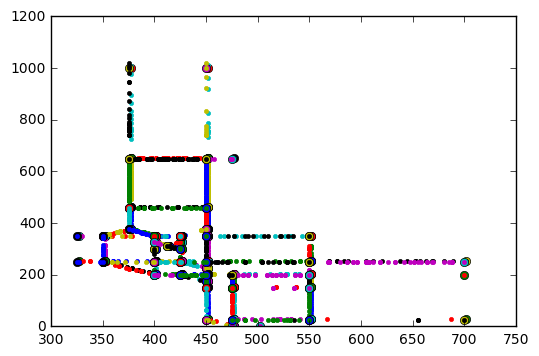

In [11]:
conn = TubeMap(loadMeta(), fwy_connectors, fix_xy, special_cases)

In [6]:
def RandomColors(data):
    import random
    r = lambda: random.randint(0,255)
    color = '#%02X%02X%02X' % (r(),r(),r())
    return color


colors = ['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#f7f7f7','#d1e5f0','#92c5de','#4393c3','#2166ac','#053061']

fwy_colors = {}
for i,(f,ds) in enumerate(conn.freeway_dict.iteritems()):
    fwy_colors[str(f)] = colors[i%len(colors)]

def GenFreewayColors():
    def FreewayColors(data):
        fwy = data.Fwy.values[1]

        fwy =  str(fwy)

        return fwy_colors[fwy]

    
    return FreewayColors
        
FreewayColors = GenFreewayColors()

def GenStationColors(stations):
    def StationColors(data):
        try:
            sid = data.ID.values[0]
            return stations[sid]
        except:
            try:
                sid = data.ID.values[1]
                return stations[sid]
            except:   
                return '#000000'
    
    return StationColors



#timestamp = pd.to_datetime('2016-01-01 10:10:00')
#StationColors = GenStationColors(station_vals[timestamp])

string = conn.GetTubeMapJson(RandomColors)
with open("../../../DSE241/final-Abraham-Hart/highway_transit/src/default_map.json", "w") as text_file:
    text_file.write(string)

In [24]:
data_5min_path = "../data/station_5min/2015/d11/"

import os 
from os.path import isfile, join
onlyfiles = [join(data_5min_path, f) for f in os.listdir(data_5min_path) if isfile(join(data_5min_path, f))]

colnames = ['Timestamp', 'Station', 'District', 'Freeway #', 'Direction', 'Lane Type', 'Station Length', 'Samples', 
            '% Observed', 'TotalFlow', 'AvgOccupancy', 'AvgSpeed', 'Lane 1 Samples', 'Lane 1 Flow', 'Lane 1 Avg Occ', 'Lane 1 Avg Speed', 'Lane 1 Observed', 'Lane 2 Samples', 'Lane 2 Flow', 'Lane 2 Avg Occ', 'Lane 2 Avg Speed', 'Lane 2 Observed', 'Lane 3 Samples', 'Lane 3 Flow', 'Lane 3 Avg Occ', 'Lane 3 Avg Speed', 'Lane 3 Observed', 'Lane 4 Samples', 'Lane 4 Flow', 'Lane 4 Avg Occ', 'Lane 4 Avg Speed', 'Lane 4 Observed', 'Lane 5 Samples', 'Lane 5 Flow', 'Lane 5 Avg Occ', 'Lane 5 Avg Speed', 'Lane 5 Observed', 'Lane 6 Samples', 'Lane 6 Flow', 'Lane 6 Avg Occ', 'Lane 6 Avg Speed', 'Lane 6 Observed', 'Lane 7 Samples', 'Lane 7 Flow', 'Lane 7 Avg Occ', 'Lane 7 Avg Speed', 'Lane 7 Observed', 'Lane 8 Samples', 'Lane 8 Flow', 'Lane 8 Avg Occ', 'Lane 8 Avg Speed', 'Lane 8 Observed']

file_content = pd.read_csv(onlyfiles[0],header=None,names=colnames)

file_content.drop(['District', 'Direction', 'Freeway #', 'Lane Type', 'Station Length', 'Samples', '% Observed', 'Lane 1 Avg Speed','Lane 1 Samples', 'Lane 1 Flow', 'Lane 1 Avg Occ','Lane 1 Observed', 'Lane 2 Samples', 'Lane 2 Flow', 'Lane 2 Avg Occ', 'Lane 2 Avg Speed', 'Lane 2 Observed', 'Lane 3 Samples', 'Lane 3 Flow', 'Lane 3 Avg Occ', 'Lane 3 Avg Speed', 'Lane 3 Observed', 'Lane 4 Samples', 'Lane 4 Flow', 'Lane 4 Avg Occ', 'Lane 4 Avg Speed', 'Lane 4 Observed', 'Lane 5 Samples', 'Lane 5 Flow', 'Lane 5 Avg Occ', 'Lane 5 Avg Speed', 'Lane 5 Observed', 'Lane 6 Samples', 'Lane 6 Flow', 'Lane 6 Avg Occ', 'Lane 6 Avg Speed', 'Lane 6 Observed', 'Lane 7 Samples', 'Lane 7 Flow', 'Lane 7 Avg Occ', 'Lane 7 Avg Speed', 'Lane 7 Observed', 'Lane 8 Samples', 'Lane 8 Flow', 'Lane 8 Avg Occ', 'Lane 8 Avg Speed', 'Lane 8 Observed'],axis=1,inplace=True)

#convert Timestate to pd.datetime
file_content.loc[:,'Timestamp'] = pd.to_datetime(file_content.loc[:,'Timestamp'], format='%m/%d/%Y %H:%M:%S')

In [4]:

data_5min_path = "../data/station_5min/2015/d11/"

import os 
from os.path import isfile, join
onlyfiles = [join(data_5min_path, f) for f in os.listdir(data_5min_path) if isfile(join(data_5min_path, f))]

colnames = ['Timestamp', 'Station', 'District', 'Freeway #', 'Direction', 'Lane Type', 'Station Length', 'Samples', 
            '% Observed', 'TotalFlow', 'AvgOccupancy', 'AvgSpeed', 'Lane 1 Samples', 'Lane 1 Flow', 'Lane 1 Avg Occ', 'Lane 1 Avg Speed', 'Lane 1 Observed', 'Lane 2 Samples', 'Lane 2 Flow', 'Lane 2 Avg Occ', 'Lane 2 Avg Speed', 'Lane 2 Observed', 'Lane 3 Samples', 'Lane 3 Flow', 'Lane 3 Avg Occ', 'Lane 3 Avg Speed', 'Lane 3 Observed', 'Lane 4 Samples', 'Lane 4 Flow', 'Lane 4 Avg Occ', 'Lane 4 Avg Speed', 'Lane 4 Observed', 'Lane 5 Samples', 'Lane 5 Flow', 'Lane 5 Avg Occ', 'Lane 5 Avg Speed', 'Lane 5 Observed', 'Lane 6 Samples', 'Lane 6 Flow', 'Lane 6 Avg Occ', 'Lane 6 Avg Speed', 'Lane 6 Observed', 'Lane 7 Samples', 'Lane 7 Flow', 'Lane 7 Avg Occ', 'Lane 7 Avg Speed', 'Lane 7 Observed', 'Lane 8 Samples', 'Lane 8 Flow', 'Lane 8 Avg Occ', 'Lane 8 Avg Speed', 'Lane 8 Observed']

df_from_each_file = (pd.read_csv(f,header=None,names=colnames) for f in onlyfiles[:2])
file_content   = pd.concat(df_from_each_file, ignore_index=True)

file_content.drop(['District', 'Direction', 'Freeway #', 'Lane Type', 'Station Length', 'Samples', '% Observed', 'Lane 1 Avg Speed','Lane 1 Samples', 'Lane 1 Flow', 'Lane 1 Avg Occ','Lane 1 Observed', 'Lane 2 Samples', 'Lane 2 Flow', 'Lane 2 Avg Occ', 'Lane 2 Avg Speed', 'Lane 2 Observed', 'Lane 3 Samples', 'Lane 3 Flow', 'Lane 3 Avg Occ', 'Lane 3 Avg Speed', 'Lane 3 Observed', 'Lane 4 Samples', 'Lane 4 Flow', 'Lane 4 Avg Occ', 'Lane 4 Avg Speed', 'Lane 4 Observed', 'Lane 5 Samples', 'Lane 5 Flow', 'Lane 5 Avg Occ', 'Lane 5 Avg Speed', 'Lane 5 Observed', 'Lane 6 Samples', 'Lane 6 Flow', 'Lane 6 Avg Occ', 'Lane 6 Avg Speed', 'Lane 6 Observed', 'Lane 7 Samples', 'Lane 7 Flow', 'Lane 7 Avg Occ', 'Lane 7 Avg Speed', 'Lane 7 Observed', 'Lane 8 Samples', 'Lane 8 Flow', 'Lane 8 Avg Occ', 'Lane 8 Avg Speed', 'Lane 8 Observed'],axis=1,inplace=True)

#convert Timestate to pd.datetime
file_content.loc[:,'Timestamp'] = pd.to_datetime(file_content.loc[:,'Timestamp'], format='%m/%d/%Y %H:%M:%S')

In [25]:
file_content.columns

Index([u'Timestamp', u'Station', u'TotalFlow', u'AvgOccupancy', u'AvgSpeed'], dtype='object')

In [26]:
#'date':{'station_id':[{'index':time,'flow':value,'speed':value,'occ':value}]}

df = file_content.copy()
df['date'] = df.Timestamp.apply(lambda x: x.date()).apply(str)
df['time'] = df.Timestamp.apply(lambda x: x.time()).apply(str)
df = df.drop('Timestamp',axis=1)
df = df.sort_values('time')

station_data = {}
for date, df_date in df.groupby('date'):
    station_data[date]={}
    for station_id, df_station in df_date.groupby('Station'):
        df_station = df_station.loc[:,['time','AvgSpeed','AvgOccupancy','TotalFlow']]
        df_station = df_station.fillna(method='pad')
        df_station = df_station.fillna(method='bfill')
        df_station = df_station.fillna(0)                      
        station_data[date][str(station_id)] = df_station.to_dict(orient='records')
        

jsonarray = json.dumps(station_data)
with open("../../../DSE241/final-Abraham-Hart/server/station_data.json", "w") as text_file:
    text_file.write(jsonarray)

In [27]:
station_data.keys()

['2015-01-01']

In [28]:

jsonarray = json.dumps(station_data['2015-01-01']['1113985'])
with open("../../../DSE241/final-Abraham-Hart/highway_transit/src/default_station_data.json", "w") as text_file:
    text_file.write(jsonarray)

In [29]:
#'category':{'date':{'time':graphdata}}

df = file_content.copy()
df['date'] = df.Timestamp.apply(lambda x: x.date()).apply(str)
df['time'] = df.Timestamp.apply(lambda x: x.time()).apply(str)
df = df.drop('Timestamp',axis=1)
df = df.sort_values('time')

colormap_flow = ['#f2f0f7','#dadaeb','#bcbddc','#9e9ac8','#756bb1','#54278f']
colormap_speed = ['#fee5d9','#fcbba1','#fc9272','#fb6a4a','#de2d26','#a50f15'][::-1]
colormap_occ = ['#edf8e9','#c7e9c0','#a1d99b','#74c476','#31a354','#006d2c']

categories = [('TotalFlow',colormap_flow),('AvgSpeed',colormap_speed),('AvgOccupancy',colormap_occ)]

color_data = {}
for (c,colormap) in categories:
    min_t = df[c].min()
    max_t = df[c].max()
    

    def getcolor(val):        
        return colormap[int(((val - min_t)/max_t)*(len(colormap)-1))]
    
    station_vals = {}
    
    color_data[c]={}
    for date, df_date in df.groupby('date'):
        color_data[c][date]={}
        for time, df_time in df_date.groupby('time'):
            
            #fill in missing values
            df_time = df_time.fillna(method='pad')
            df_time = df_time.fillna(method='bfill')
            df_time['color']=df_time[c].apply(lambda x: getcolor(x))

            color_data[c][date][time] = df_time.drop(['TotalFlow','AvgSpeed','AvgOccupancy','time','date'],axis = 1).set_index('Station').to_dict()['color']

In [30]:
color_data['AvgSpeed']['2015-01-01']['17:35:00'][1100461]

'#fc9272'

In [31]:
graph_data = {}
for c,c_d in color_data.iteritems():
    graph_data[c]={}
    for d,d_d in c_d.iteritems():
        graph_data[c][d]={}
        for t,t_d in d_d.iteritems():
            tube_map = conn.GetTubeMapJson(GenStationColors(t_d))
            graph_data[c][d][t]=tube_map


In [32]:
#graph_data['AvgSpeed']['2015-01-01']['17:35:00']

In [33]:
jsonarray = json.dumps(graph_data)
with open("../../../DSE241/final-Abraham-Hart/server/graph_data.json", "w") as text_file:
    text_file.write(jsonarray)

In [34]:
color_data['AvgSpeed'].keys()

['2015-01-01']

In [35]:
selector = {'stations':station_data['2015-01-01'].keys(),'categories':graph_data.keys(), 'dates':graph_data['AvgSpeed'].keys(),'times':sorted(graph_data['AvgSpeed']['2015-01-01'].keys())}
jsonarray = json.dumps(selector)
with open("../../../DSE241/final-Abraham-Hart/highway_transit/src/selector.json", "w") as text_file:
    text_file.write(jsonarray)

# Math experiments

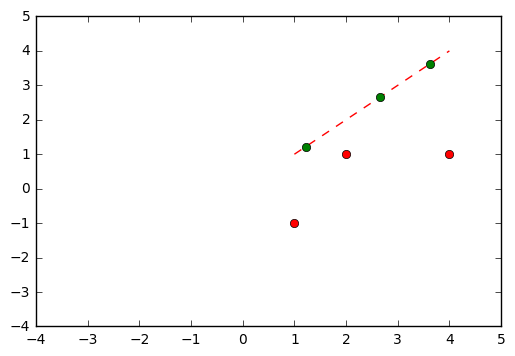

In [7]:
#jeebus christ, how difficult should it be to project a point on a line
#project and scale

X = np.array([[1.0,1.0],
              [4.0,4.0]])
p = np.array([[1.0,-1.0],
             [2.0,1.0],
             [4.0,1.0]])

trans = np.array([X[0,:]])

X_trans = X-trans
X_trans = X_trans[1,:]
p_trans = p-trans


t = np.array([np.dot(p_trans,X_trans)])
b = np.array([np.dot(X_trans,X_trans)])

c_p = np.divide(t,b)
p_proj =  np.dot(c_p.T,np.array([X_trans])) 

#translate back
p_proj = p_proj + trans

v = (X,p,X_trans,p_proj)

#scale
p_max = np.max(p_proj,axis = 0)
p_min = np.min(p_proj,axis = 0)

center = np.sum(p_proj,axis=0)/len(p_proj)
center_x = np.sum(X,axis=0)/len(X)

p_proj = p_proj - center
scale =  np.linalg.norm(p_max-p_min)
x_scale = np.linalg.norm(X_trans)

p_proj = p_proj / scale
p_proj = p_proj * x_scale*0.8
p_proj = p_proj + center_x






plt.axis([-4, 5, -4, 5],'equal')
x,y = X[:,0], X[:,1]
plt.plot(x,y,'--',color='r')


x,y = p[:,0], p[:,1]
plt.plot(x,y,'o',color='r')


x,y = p_proj[:,0], p_proj[:,1]
plt.plot(x,y,'o',color='g')
plt.show()


[ 2.5  2.5]
[ 1.33333333  1.33333333]
[[ 1.59490332  1.59490332]
 [ 2.61313708  2.61313708]
 [ 3.29195959  3.29195959]]
pmax [ 2.5  2.5] pmin [ 0.  0.] scale 2.5 center [ 1.33333333  1.33333333] xscale 1.69705627485
[[ 1.59490332  1.59490332]
 [ 2.61313708  2.61313708]
 [ 3.29195959  3.29195959]]


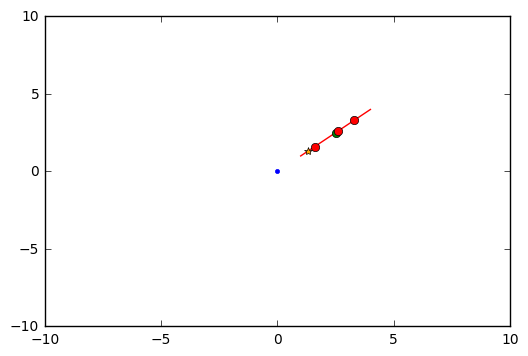

In [8]:
#scale test
plt.axis([-10, 10, -10, 10],'equal')

X = np.array([[1.0,1.0],
              [4.0,4.0]])
p = np.array([[1.0,1.0],
             [2.0,2.0],
             [3.0,3.0],
             [4.0,4.0]])


trans = np.array([X[0,:]])

X_trans = (X-trans)[1,:] 

p_proj = p-trans

X,p,X_trans,p_proj = v

x,y = X[:,0], X[:,1]
plt.plot(x,y,'-',color='r')



p_max = np.max(p_proj,axis = 0)
p_min = np.min(p_proj,axis = 0)

center = np.sum(p_proj,axis=0)/len(p_proj)
center_x = np.sum(X,axis=0)/len(X)

p_proj = p_proj - center
scale = np.max(p_max-p_min)
x_scale = np.linalg.norm(X_trans)/2.5

p_proj = p_proj / scale
p_proj = p_proj * x_scale
p_proj = p_proj + center_x


plt.plot(0,0,'.',color='b')


print center_x
x,y = center_x[0], center_x[1]
plt.plot(x,y,'o',color='green')

print center
x,y = center[0], center[1]
plt.plot(x,y,'*',color='orange')

print p_proj
x,y = p_proj[:,0], p_proj[:,1]
plt.plot(x,y,'o',color='r')


print 'pmax',p_max,'pmin',p_min,'scale',scale,'center', center, 'xscale',x_scale
print p_proj

# 
#Center the data on the origin:
P.x -= (maxX - minX) / 2
P.y -= (maxY - minY) / 2
#Scale it down by the same amount in both dimensions, such that the larger of the two ranges becomes (-0.5, 0.5):
scale = max(maxX - minX, maxY - minY)
P.x /= scale
P.y /= scale
#Translate the points by (0.5, 0.5) to bring everything where you want it:
P.x += 0.5
P.y += 0.5


x = [p[0] for p in points]
y = [p[1] for p in points]
centroid = (sum(x) / len(points), sum(y) / len(points))

p = np.array([[1.0,2.0],
             [2.0,2.0],
             [1.0,2.0],
             [2.0,1.0]])

np.sum(p,axis=0)/len(p)

np.linalg.norm(X_trans)

# Failed experiments go here

#build snaps
meta_frame = loadMeta()
meta_frame = buildXY(meta_frame) 
fwy_colors, freeway_dict, labelPos_dict = build_dicts(meta_frame) 
connector_frame = detectConnectors(meta_frame, fwy_colors, freeway_dict, labelPos_dict)
#connector_frame = addConnectors(meta_frame, connector_frame, connectors)
#connector_frame = addEndpoints(meta_frame, connector_frame, endpoints)

df = pd.DataFrame()

for f, group in connector_frame.groupby('Fwy'): 
    
    sortby = ['Y','X']
    if 'N' in freeway_dict[f] or 'S' in freeway_dict[f]:
        sortby = ['X','Y']
        
    group = group.sort_values(sortby,ascending=False)
    group = group.reset_index(drop=True)
    
    snap_dir = 'X'
    if group.X.std() > group.Y.std():
        snap_dir = 'Y'
    
    group[snap_dir] = round(group[snap_dir].mean())
    group['use'] = snap_dir
    
    df = pd.concat([df,group])



df2 = pd.DataFrame()

for f, group in df.groupby('name'): 
    dims = group.use.unique()
    for d in dims:
        group[d]=round(group[group.use==d][d].mean())
        
    df2 = pd.concat([df2,group])


plt.plot(connector_frame.X, connector_frame.Y, '.')
plt.plot(df2.X, df2.Y, 'o')

connector_frame=df2
connector_frame

#oh snap
import bisect
def snap(myGrid, myValue):
    ix = bisect.bisect_right(myGrid, myValue)
    if ix == 0:
        return myGrid[0]
    elif ix == len(myGrid):
        return myGrid[-1]
    else:
        return min(myGrid[ix - 1], myGrid[ix], key=lambda gridValue: abs(gridValue - myValue))
       
#myGrid = np.array([[0,0],[0,1],[0,2],[0,3],[1,0],[1,1],[1,2],[1,3],[2,0],[2,1],[2,2],[2,3],[3,0],[3,1],[3,2],[3,3]]) 
#myGrid = np.array(range(0,10,1)) 
#myValue = 0.3
#snap(myGrid, myValue)

meta_frame = loadMeta()
meta_frame = buildXY(meta_frame) 
fwy_colors, freeway_dict, labelPos_dict = build_dicts(meta_frame) 
connector_frame = detectConnectors(meta_frame, fwy_colors, freeway_dict, labelPos_dict)
connector_frame = addConnectors(meta_frame, connector_frame, connectors)
connector_frame = addEndpoints(meta_frame, connector_frame, endpoints)

maxX = int(round(connector_frame.X.max()))
minX = int(round(connector_frame.X.min()))

maxY = int(round(connector_frame.Y.max()))
minY = int(round(connector_frame.Y.min()))

print maxX, maxY, minX, minY

X_snap_grid = np.array(range(minX, maxX, (maxX - minX)/15))
Y_snap_grid = np.array(range(minY, maxY, (maxY - minY)/15)) 

connector_frame['snap_X'] = connector_frame.X.apply(lambda x:snap(X_snap_grid, x))
connector_frame['snap_Y'] = connector_frame.Y.apply(lambda y:snap(Y_snap_grid, y))

plt.plot(connector_frame.snap_X, connector_frame.snap_Y, 'o')
plt.plot(connector_frame.X, connector_frame.Y, '.')

def detectConnectors(meta_frame, fwy_colors, freeway_dict, labelPos_dict):
    #try to find our freeway connectors
    locations = meta_frame[['ID','Latitude','Longitude','X','Y']].set_index('ID').to_dict('index')

    df = meta_frame[meta_frame.Type=='FF']

    df = meta_frame

    def fwydir(fwy):
        l = []
        for f in fwy:
            if f in freeway_dict:
                l = l + [f]
        return l

    def nameParse(name):
        simple = "".join([ c if  c.isdigit() else " " for c in name ])

        rds = simple.split()
        rds = list(set(rds))
        rds = fwydir(rds)
        rds = filter(None, rds)
        rds = sorted(rds)

        return rds


    df['connector'] = df.Name + " " + df.Fwy.apply(str)
    df.connector = df.connector.apply(nameParse)

    df['group'] = df.connector.apply(str)
    df = df[df.connector.apply(len)>=2]
    df = df.groupby('group')['ID'].apply(list).to_frame().reset_index()

    df['Latitude'] = df.ID.apply(lambda x: np.mean([locations[n]['Latitude'] for n in x]))
    df['Longitude'] = df.ID.apply(lambda x: np.mean([locations[n]['Longitude'] for n in x]))

    df['X'] = df.ID.apply(lambda x: np.mean([locations[n]['X'] for n in x]))
    df['Y'] = df.ID.apply(lambda x: np.mean([locations[n]['Y'] for n in x]))

    df.group = df.group.apply(lambda x:ast.literal_eval(x))

    df = df.drop('ID',axis =1)

    df['name'] = df.group.apply(lambda x:str(x[0])) + ' <-> ' +df.group.apply(lambda x:str(x[1]))

    df['labelPos'] = df.group.apply(lambda x:freeway_dict[x[0]][0]) + '' +df.group.apply(lambda x:freeway_dict[x[1]][0])
    df['labelPos'] = df.labelPos.apply(lambda x:fix_dir_dict[str(x)])
    
    
    df_x_y = df.copy()
    df_y_x = df.copy()
    
    df_x_y['dir'] = df_x_y.group.apply(lambda x:freeway_dict[x[0]][0])
    df_y_x['dir'] = df.group.apply(lambda x:freeway_dict[x[1]][0])
    
    df_x_y['Fwy'] = df_x_y.group.apply(lambda x:str(x[0]))
    df_y_x['Fwy'] = df_y_x.group.apply(lambda x:str(x[1]))

    df_x_y = df_x_y[df_x_y.Fwy.apply(lambda x: int(x) in usefwy)]
    df_y_x = df_y_x[df_y_x.Fwy.apply(lambda x: int(x) in usefwy)]

    df = pd.concat([df_x_y,df_y_x])
    df = df.drop('group', axis = 1)
    df = df.reset_index(drop=True)

    df['labelPos'] = df.dir

    return df

meta_frame = loadMeta()
meta_frame = buildXY(meta_frame) 
fwy_colors, freeway_dict, labelPos_dict = build_dicts(meta_frame) 
connector_frame = detectConnectors(meta_frame, fwy_colors, freeway_dict, labelPos_dict)
connector_frame.head(1)